# EEG Data interpretation -  Meditation and Individual Alpha Frequency (iAF)

## 1. Import Libraries and Setup


In [1]:
import mne
import pandas as pd
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# inline plotting
%matplotlib inline

# get the directory where this notebook is located
script_dir = Path.cwd()

## 2. Load EEG Data


In [2]:
raw_classical_1 = mne.io.read_raw_brainvision(
        script_dir / "data/classical_A_M_2025-12-15_15-04-18.vhdr",
        preload=True
    )

raw_classical_2 = mne.io.read_raw_brainvision(
        script_dir / "data/classical_A_S_2025-12-18_10-40-05.vhdr",
        preload=True
    )

raw_classical_3 = mne.io.read_raw_brainvision(
        script_dir / "data/classical_S_HA_2025-12-18_14-05-33.vhdr",
        preload=True
    )

raw_rock_1 = mne.io.read_raw_brainvision(
        script_dir / "data/rock_B_A_2025-12-18_15-13-43.vhdr",
        preload=True
    )

raw_rock_2 = mne.io.read_raw_brainvision(
        script_dir / "data/rock_S_H_2025-12-18_11-57-47.vhdr",
        preload=True
    )

raw_rock_3 = mne.io.read_raw_brainvision(
        script_dir / "data/rock_S_M_2025-12-15_16-11-41.vhdr",
        preload=True
    )

Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\classical_A_M_2025-12-15_15-04-18.vhdr...
Setting channel info structure...
Reading 0 ... 651019  =      0.000 ...  1302.038 secs...
Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\classical_A_S_2025-12-18_10-40-05.vhdr...
Setting channel info structure...
Reading 0 ... 743975  =      0.000 ...  1487.950 secs...
Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\classical_S_HA_2025-12-18_14-05-33.vhdr...


C:\Users\bicle\AppData\Local\Temp\ipykernel_3888\3328176140.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_classical_1 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_3888\3328176140.py:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_classical_2 = mne.io.read_raw_brainvision(


Setting channel info structure...
Reading 0 ... 696130  =      0.000 ...  1392.260 secs...
Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\rock_B_A_2025-12-18_15-13-43.vhdr...
Setting channel info structure...
Reading 0 ... 748190  =      0.000 ...  1496.380 secs...
Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\rock_S_H_2025-12-18_11-57-47.vhdr...
Setting channel info structure...


C:\Users\bicle\AppData\Local\Temp\ipykernel_3888\3328176140.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_classical_3 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_3888\3328176140.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_rock_1 = mne.io.read_raw_brainvision(


Reading 0 ... 739870  =      0.000 ...  1479.740 secs...
Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\rock_S_M_2025-12-15_16-11-41.vhdr...
Setting channel info structure...
Reading 0 ... 659050  =      0.000 ...  1318.100 secs...


C:\Users\bicle\AppData\Local\Temp\ipykernel_3888\3328176140.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_rock_2 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_3888\3328176140.py:26: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_rock_3 = mne.io.read_raw_brainvision(


In [3]:
# 'standard_1020' - standard 10-20 system positions
montage = mne.channels.make_standard_montage('standard_1020')
raw_classical_1.set_montage(montage, match_case=False, on_missing='ignore')
raw_classical_2.set_montage(montage, match_case=False, on_missing='ignore')
raw_classical_3.set_montage(montage, match_case=False, on_missing='ignore')
raw_rock_1.set_montage(montage, match_case=False, on_missing='ignore')
raw_rock_2.set_montage(montage, match_case=False, on_missing='ignore')
raw_rock_3.set_montage(montage, match_case=False, on_missing='ignore')

<RawBrainVision | Rock_S_M_2025-12-15_16-11-41.eeg, 22 x 659051 (1318.1 s), ~110.7 MiB, data loaded>

## 3. Visualize Raw Data


In [4]:
# plot raw data (Use show=False to prevent auto-display, then show explicitly)

#TODO: uncomment to visualize raw data and change raw_music_number to desired variable
raw_rock_1.plot(duration=10.0, n_channels=22, scalings='auto', title='Classical Music - Raw Data', show=False)
plt.show()


Using qt as 2D backend.


## Interpretation of Raw Time-Series Data: A_M

- Frontal/Central channels show high-amplitude artifacts: Channels FPz, FCz, F9, F3, F4, F10, Cz, M1, T7, C3, C4, T8, M2 display very high amplitude, irregular, noisy activity with sharp deflections
- Posterior channels appear cleaner: Channels P9, P7, P3, Pz, P4, P8, P10, O1, O2 show lower amplitude, more organized waveforms typical of EEG signals
- Likely causes of artifacts: Muscle activity (jaw, neck, facial), electrode contact issues (high impedance (electrical resistance of the scalp)), or movement artifacts in frontal/central regions
- Recording quality: Posterior channels suggest the recording setup is generally functional; issues appear localized to specific electrodes

In [ ]:
# Power spectral density of raw data

# TODO: uncomment to visualize psd and change raw_music_number to desired variable
# fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# psd = raw_music_number.compute_psd(fmax=100)
# psd.plot(axes=ax, show=False)
# ax.set_title('Raw Data - Power Spectral Density')
# plt.show()

## Interpretation of PSD Plot: A_M
- Prominent 50 Hz line noise: Sharp peak around 50 Hz across most channels, indicating power line interference that needs notch filtering (applies for all users)
- High power at low frequencies: Elevated power in the delta/theta range (2-8 Hz), typical of EEG baseline activity
- Alpha/beta activity present: Broad peaks around 10-25 Hz, indicating alpha and beta band activity
- Power decreases with frequency: General decline from low to high frequencies, consistent with EEG
- Channel variability: Differences in power levels across channels, reflecting spatial differences in brain activity
- Pre-filtering state: This is raw data; the 50 Hz peak should be removed with notch filtering (50, 100 Hz)
- Frequency content: Most power concentrated below 40 Hz, supporting the 1-40 Hz bandpass filter range

## 4. Preprocessing Pipeline


### 4.1 Notch Filtering (Remove Line Noise)


In [6]:
# copy for preprocessing
raw_classical_1_filtered = raw_classical_1.copy()
raw_classical_2_filtered = raw_classical_2.copy()
raw_classical_3_filtered = raw_classical_3.copy()
raw_rock_1_filtered = raw_rock_1.copy()
raw_rock_2_filtered = raw_rock_2.copy()
raw_rock_3_filtered = raw_rock_3.copy()

# 50 and 100 Hz notch filters
raw_classical_1_filtered.notch_filter([50, 100])
raw_classical_2_filtered.notch_filter([50, 100])
raw_classical_3_filtered.notch_filter([50, 100])
raw_rock_1_filtered.notch_filter([50, 100])
raw_rock_2_filtered.notch_filter([50, 100])
raw_rock_3_filtered.notch_filter([50, 100])


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

<RawBrainVision | Rock_S_M_2025-12-15_16-11-41.eeg, 22 x 659051 (1318.1 s), ~110.7 MiB, data loaded>

### 4.2 Bandpass Filtering (Keep 1-40 Hz)


In [7]:
# bandpass filter - 1-40 hz
raw_classical_1_filtered.filter(l_freq=1, h_freq=40)
raw_classical_2_filtered.filter(l_freq=1, h_freq=40)
raw_classical_3_filtered.filter(l_freq=1, h_freq=40)
raw_rock_1_filtered.filter(l_freq=1, h_freq=40)
raw_rock_2_filtered.filter(l_freq=1, h_freq=40)
raw_rock_3_filtered.filter(l_freq=1, h_freq=40)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 

<RawBrainVision | Rock_S_M_2025-12-15_16-11-41.eeg, 22 x 659051 (1318.1 s), ~110.7 MiB, data loaded>

In [8]:
# TODO: uncomment to visualize psd before and after filtering and change raw_music_number to desired variable
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Data PSD before filtering
# psd_before = raw_music_number.compute_psd(fmax=100)
# psd_before.plot(axes=axes[0], show=False)
# axes[0].set_title('Data PSD before Filtering')

# # Data PSD after filtering
# psd_after = raw_music_number_filtered.compute_psd(fmax=100)
# psd_after.plot(axes=axes[1], show=False)
# axes[1].set_title('Data PSD after Filtering')

# plt.show()


In [9]:
# TODO: uncomment to visualaze zoomed in psd and change raw_music_number to desired variable
# pre-ICA PSD: Focus on theta and alpha bands only for iAF analysis
# fig, ax = plt.subplots(figsize=(12, 8))

# psd_after = raw_music_number_filtered.compute_psd(
#     method='welch',
#     fmin=3.0, 
#     fmax=15.0, 
#     n_fft=4096, 
#     n_overlap=1024
# )

# psd_after.plot(axes=ax, show=False, picks='eeg', average=False)
# ax.set_title('Data PSD after Filtering - Theta (4-8 Hz) & Alpha (8-13 Hz) Focus', 
#             fontsize=14, fontweight='bold')
# ax.set_xlim(3, 15)
# ax.set_ylim(-40, 20)
# ax.set_xlabel('Frequency (Hz)', fontsize=12)
# ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

# ax.axvline(4, color='gray', linestyle='--', alpha=0.5, linewidth=1)
# ax.axvline(8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
# ax.axvline(13, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# ax.axvspan(4, 8, alpha=0.05, color='gray', linewidth=0)
# ax.axvspan(8, 13, alpha=0.05, color='gray', linewidth=0)

# ax.grid(True, alpha=0.3, linestyle='--')
# plt.show()

### 4.3 ICA - Independent Component Analysis (Remove Artifacts)


In [10]:

# fit ica on filtered data
ica_classical_1 = ICA(n_components=20, random_state=97, max_iter='auto')
ica_classical_1.fit(raw_classical_1_filtered)

ica_classical_2 = ICA(n_components=20, random_state=97, max_iter='auto')
ica_classical_2.fit(raw_classical_2_filtered)

ica_classical_3 = ICA(n_components=20, random_state=97, max_iter='auto')
ica_classical_3.fit(raw_classical_3_filtered)

ica_rock_1 = ICA(n_components=20, random_state=97, max_iter='auto')
ica_rock_1.fit(raw_rock_1_filtered)

ica_rock_2 = ICA(n_components=20, random_state=97, max_iter='auto')
ica_rock_2.fit(raw_rock_2_filtered)

ica_rock_3 = ICA(n_components=20, random_state=97, max_iter='auto')
ica_rock_3.fit(raw_rock_3_filtered)

# show ica components

# TODO: uncomment to visualize ica components and change raw_music_number to desired variable
# fig = ica_music_number.plot_components()

# TODO: find artifacts to exclude in the next step

Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 154.6s.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 198.5s.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 82.6s.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 130.6s.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 123.5s.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 138.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,41 iterations on raw data (659051 samples)
ICA components,20
Available PCA components,22
Channel types,eeg
ICA components marked for exclusion,—


In [11]:
# ICA component properties - helps you find artifacts
# look for
# - activity frontal channels - eye blinks
# - activity temporal channels - muscle artifacts
# - unusual frequency content


# TODO: uncomment to visualize ica component properties and change ica_music_number to desired variable
# ica_music_number.plot_properties(raw_music_number_filtered, picks=[1,2,3,8]) # change picks as needed


### 4.4 Apply ICA (Remove Artifacts)

**!!! IMPORTANT !!!** Before running this cell, you should:
1. Inspect the ICA components
2. Identify rtifacts
3. Set `ica.exclude`


In [12]:
ica_classical_1.exclude = [1,3,4,6,16]  # indexes of excluded components
ica_classical_2.exclude = [0,3,5,19]  # indexes of excluded components
ica_classical_3.exclude = [0,3,4,5,19]  # indexes of excluded components
ica_rock_1.exclude = [0,4,6,13,17]  # indexes of excluded components
ica_rock_2.exclude = [1,2,13,15,17,18,19]  # indexes of excluded components
ica_rock_3.exclude = [1,3,5,6,8,12]  # indexes of excluded components

# apply ICA
raw_classical_1_clean = ica_classical_1.apply(raw_classical_1_filtered.copy())
raw_classical_2_clean = ica_classical_2.apply(raw_classical_2_filtered.copy())
raw_classical_3_clean = ica_classical_3.apply(raw_classical_3_filtered.copy())
raw_rock_1_clean = ica_rock_1.apply(raw_rock_1_filtered.copy())
raw_rock_2_clean = ica_rock_2.apply(raw_rock_2_filtered.copy())
raw_rock_3_clean = ica_rock_3.apply(raw_rock_3_filtered.copy())

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 22 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 22 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 22 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 22 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 7 ICA components
    Projecting back using 22 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 22 PCA components


## 5. Visualize Cleaned Data


In [13]:
# plot clean data

# TODO: uncomment to visualize cleaned data and change raw_music_number to desired variable
# raw_music_number_clean.plot(duration=10.0, n_channels=22, scalings='auto', 
#                        title='Cleaned Data', show=False)
# plt.show()

In [14]:
# compare psd before and after cleaning

# TODO: uncomment to visualize psd before and after filtering and change raw_music_number to desired variable
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Raw data
# psd_raw = raw_music_number.compute_psd(fmax=50)
# psd_raw.plot(axes=axes[0], show=False)
# axes[0].set_title('Raw Data')

# # Cleaned data
# psd_clean = raw_music_number_clean.compute_psd(fmax=50)
# psd_clean.plot(axes=axes[1], show=False)
# axes[1].set_title('Cleaned Data')

# plt.show()

In [15]:
# post-ICA PSD: Full filtered range (1-40 Hz)

# TODO: uncomment to visualize cleaned psd and change raw_music_number to desired variable
# fig, ax = plt.subplots(figsize=(12, 8))

# psd_clean = raw_music_number_clean.compute_psd(
#     method='welch',
#     fmin=1.0, 
#     fmax=40.0, 
#     n_fft=4096, 
#     n_overlap=1024
# )

# psd_clean.plot(axes=ax, show=False, picks='eeg', average=False)
# ax.set_title('Cleaned Data PSD - Full Filtered Range (1-40 Hz)', 
#             fontsize=14, fontweight='bold')
# ax.set_xlim(1, 40)
# ax.set_ylim(-40, 20)
# ax.set_xlabel('Frequency (Hz)', fontsize=12)
# ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

# ax.grid(True, alpha=0.3, linestyle='--')
# plt.show()

In [16]:
# post-ICA PSD: Focus on theta and alpha bands only for iAF analysis


# TODO: uncomment to visualize cleaned psd and change raw_music_number to desired variable
# fig, ax = plt.subplots(figsize=(12, 8))

# psd_clean = raw_music_number_clean.compute_psd(
#     method='welch',
#     fmin=3.0, 
#     fmax=15.0, 
#     n_fft=4096, 
#     n_overlap=1024
# )

# psd_clean.plot(axes=ax, show=False, picks='eeg', average=False)
# ax.set_title('Cleaned Data PSD - Theta (4-8 Hz) & Alpha (8-13 Hz) Focus', 
#             fontsize=14, fontweight='bold')
# ax.set_xlim(3, 15)
# ax.set_ylim(-20, 20)
# ax.set_xlabel('Frequency (Hz)', fontsize=12)
# ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

# ax.grid(True, alpha=0.3, linestyle='--')
# plt.show()

## 6. Epoching

Segment the continuous data into epochs based on experimental protocol phases.
s1000 marks the protocol start, and s1050 markers indicate the end of each phase.


In [17]:
protocol_starts = []

raw_datasets = [
    raw_classical_1_clean,
    raw_classical_2_clean,
    raw_classical_3_clean,
    raw_rock_1_clean,
    raw_rock_2_clean,
    raw_rock_3_clean,
]

for idx, raw in enumerate(raw_datasets, start=1):
    start_time = None

    # find s1000
    for onset, description in zip(raw.annotations.onset, raw.annotations.description):
        if 's1000' in str(description):
            start_time = onset
            break

    # no s1000? find s1050
    if start_time is None:
        for onset, description in zip(raw.annotations.onset, raw.annotations.description):
            if 's1050' in str(description):
                start_time = onset
                break

    protocol_starts.append(start_time)
    print(f"Dataset {idx}: start = {start_time:.1f}s")


Dataset 1: start = 116.1s
Dataset 2: start = 7.3s
Dataset 3: start = 14.3s
Dataset 4: start = 16.2s
Dataset 5: start = 13.4s
Dataset 6: start = 77.8s


In [18]:
base_phase_durations = [120, 120, 120, 60, 120, 60, 600]
post_task_duration = 120

datasets_with_7_phases = {1, 6}  # classical_1 and rock_3

all_phase_boundaries = {}

for idx, raw in enumerate(raw_datasets, start=1):

    protocol_start = None
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        if 's1000' in str(desc):
            protocol_start = onset
            break
    if protocol_start is None:
        protocol_start = raw.annotations.onset[0] if len(raw.annotations) > 0 else 0.0

    print(f"Dataset {idx}: start = {protocol_start:.1f}s")

    current_time = protocol_start
    recording_end = raw.times[-1]
    phase_boundaries = {}

    for i, duration in enumerate(base_phase_durations, start=1):
        phase_name = f"phase_{i}"
        phase_start = current_time
        phase_end = min(current_time + duration, recording_end)
        phase_boundaries[phase_name] = (phase_start, phase_end)
        current_time = phase_end

    if idx not in datasets_with_7_phases:
        phase_start = current_time
        phase_end = min(current_time + post_task_duration, recording_end)
        phase_boundaries["phase_8"] = (phase_start, phase_end)

    all_phase_boundaries[idx] = phase_boundaries

    print(f"\nDataset {idx} phases")
    for phase, (start, end) in phase_boundaries.items():
        dur = end - start
        print(f"  {phase}: {start:.1f}s – {end:.1f}s ({dur/60:.1f} min)")


Dataset 1: start = 116.1s

Dataset 1 phases
  phase_1: 116.1s – 236.1s (2.0 min)
  phase_2: 236.1s – 356.1s (2.0 min)
  phase_3: 356.1s – 476.1s (2.0 min)
  phase_4: 476.1s – 536.1s (1.0 min)
  phase_5: 536.1s – 656.1s (2.0 min)
  phase_6: 656.1s – 716.1s (1.0 min)
  phase_7: 716.1s – 1302.0s (9.8 min)
Dataset 2: start = 0.0s

Dataset 2 phases
  phase_1: 0.0s – 120.0s (2.0 min)
  phase_2: 120.0s – 240.0s (2.0 min)
  phase_3: 240.0s – 360.0s (2.0 min)
  phase_4: 360.0s – 420.0s (1.0 min)
  phase_5: 420.0s – 540.0s (2.0 min)
  phase_6: 540.0s – 600.0s (1.0 min)
  phase_7: 600.0s – 1200.0s (10.0 min)
  phase_8: 1200.0s – 1320.0s (2.0 min)
Dataset 3: start = 0.0s

Dataset 3 phases
  phase_1: 0.0s – 120.0s (2.0 min)
  phase_2: 120.0s – 240.0s (2.0 min)
  phase_3: 240.0s – 360.0s (2.0 min)
  phase_4: 360.0s – 420.0s (1.0 min)
  phase_5: 420.0s – 540.0s (2.0 min)
  phase_6: 540.0s – 600.0s (1.0 min)
  phase_7: 600.0s – 1200.0s (10.0 min)
  phase_8: 1200.0s – 1320.0s (2.0 min)
Dataset 4: start

In [19]:
# Map phase boundaries to your experimental protocol
phase_labels = {
    'phase_1': 'baseline_EO',      # Eyes Open (2 min)
    'phase_2': 'baseline_EC',      # Eyes Closed (2 min)
    'phase_3': 'task_no_music',    # No music + finger tapping (2 min)
    'phase_4': 'break1',           # Break (1 min)
    'phase_5': 'task_music',      # Music + finger tapping (2 min)
    'phase_6': 'break2',          # Break (1 min)
    'phase_7': 'meditation',      # Meditation (10 min)
    'phase_8': 'post_EC'        # Post-meditation Eyes Closed (if exists, not available in all subjects)
}

# Create labeled phase boundaries
labeled_phases = {}
for phase_num, (start, end) in phase_boundaries.items():
    label = phase_labels.get(phase_num, phase_num)
    labeled_phases[label] = (start, end)
    
print(f"\nLabeled phases (using fixed durations):")
for phase_num, (start, end) in phase_boundaries.items():
    label = phase_labels.get(phase_num, phase_num)
    duration = end - start
    expected = expected_phase_durations.get(phase_num, None)
    if expected:
        diff = duration - expected
        status = "✓" if abs(diff) < 1.0 else "⚠️"
        print(f"  {status} {label}: {start:.1f}s - {end:.1f}s ({duration:.1f}s = {duration/60:.1f} min, expected: {expected}s, diff: {diff:+.1f}s)")
    else:
        print(f"  {label}: {start:.1f}s - {end:.1f}s ({duration:.1f}s = {duration/60:.1f} min)")


Labeled phases (using fixed durations):


NameError: name 'expected_phase_durations' is not defined

In [ ]:
# Create epochs for each experimental phase
epoch_duration = 30.0 
# figure out if this is the right length for an epoch within this context
epoch_overlap = 0.0   

epochs_by_phase = {}

for phase_name, (abs_start, abs_end) in labeled_phases.items():
    # Check if phase is within recording
    if abs_end > raw_data_clean.times[-1]:
        print(f" {phase_name}: Phase extends beyond recording, adjusting end time")
        abs_end = raw_data_clean.times[-1]
    
    if abs_start < raw_data_clean.times[-1] and abs_end > abs_start:
        try:
            # Crop raw data to this phase
            raw_phase = raw_data_clean.copy().crop(tmin=abs_start, tmax=abs_end)
            
            # Create fixed-length epochs
            epochs_phase = mne.make_fixed_length_epochs(
                raw_phase,
                duration=epoch_duration,
                overlap=epoch_overlap,
                preload=True
            )
            
            epochs_by_phase[phase_name] = epochs_phase
            duration_min = (abs_end - abs_start) / 60
            print(f"✓ {phase_name}: Created {len(epochs_phase)} epochs ({abs_start:.1f}s - {abs_end:.1f}s, {duration_min:.1f} min)")
        except Exception as e:
            print(f" {phase_name}: Error creating epochs - {e}")
    else:
        print(f" {phase_name}: Invalid time range, skipping")

print(f"\n✓ Total phases with epochs: {len(epochs_by_phase)}")

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 15000 original time points ...
0 bad epochs dropped
✓ baseline_EO: Created 4 epochs (116.1s - 236.1s, 2.0 min)
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 15000 original time points ...
0 bad epochs dropped
✓ baseline_EC: Created 4 epochs (236.1s - 356.1s, 2.0 min)
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 15000 original time points ...
0 bad epochs dropped
✓ task_no_music: Created 4 epochs (356.1s - 476.1s, 2.0 min)
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 15000 original time points ...
0 bad epochs dropped
✓ bre

In [ ]:
# Verify phase durations match expected protocol
expected_durations = {
    'baseline_EO': 120,      
    'baseline_EC': 120,      
    'task_no_music': 120,   
    'break1': 60,          
    'task_music': 120,      
    'break2': 60,          
    'meditation': 600,
    'post_EC': 120          
}

print("\n=== Phase Duration Verification ===")
for phase_name, epochs_phase in epochs_by_phase.items():
    actual_duration = len(epochs_phase) * epoch_duration
    expected = expected_durations.get(phase_name, None)
    
    if expected:
        diff = actual_duration - expected
        print(f"{phase_name}: {actual_duration:.1f}s (expected: {expected}s, diff: {diff:+.1f}s)")
    else:
        print(f"{phase_name}: {actual_duration:.1f}s (no expected duration)")


=== Phase Duration Verification ===
baseline_EO: 120.0s (expected: 120s, diff: +0.0s)
baseline_EC: 120.0s (expected: 120s, diff: +0.0s)
task_no_music: 120.0s (expected: 120s, diff: +0.0s)
break1: 60.0s (expected: 60s, diff: +0.0s)
task_music: 120.0s (expected: 120s, diff: +0.0s)
break2: 60.0s (expected: 60s, diff: +0.0s)
meditation: 570.0s (expected: 600s, diff: -30.0s)


In [ ]:
# Create combined epochs with metadata

all_epochs_list = []
all_metadata_list = []

for phase_name, epochs_phase in epochs_by_phase.items():
    n_epochs = len(epochs_phase)
    phase_metadata = pd.DataFrame({
        'phase': [phase_name] * n_epochs,
        'epoch_in_phase': range(n_epochs)
    })
    
    epochs_phase.metadata = phase_metadata
    all_epochs_list.append(epochs_phase)
    all_metadata_list.append(phase_metadata)

# Combine all epochs
if len(all_epochs_list) > 0:
    epochs_all_phases = mne.concatenate_epochs(all_epochs_list)
    epochs_all_phases.metadata = pd.concat(all_metadata_list, ignore_index=True)
    
    print(f"\n✓ Combined epochs: {len(epochs_all_phases)} total epochs")
    print(f"\nEpochs by phase:")
    print(epochs_all_phases.metadata['phase'].value_counts().to_dict())
else:
    print("No epochs created")

Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
39 matching events found
No baseline correction applied
Replacing existing metadata with 2 columns

✓ Combined epochs: 39 total epochs

Epochs by phase:
{'meditation': 19, 'baseline_EO': 4, 'baseline_EC': 4, 'task_no_music': 4, 'task_music': 4, 'break1': 2, 'break2': 2}


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_2346/2818534857.py:19: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_all_phases = mne.concatenate_epochs(all_epochs_list)


In [ ]:
# Summary table of epochs by phase
summary_data = []
for phase_name, epochs_phase in epochs_by_phase.items():
    n_epochs = len(epochs_phase)
    phase_start = labeled_phases[phase_name][0]
    phase_end = labeled_phases[phase_name][1]
    phase_duration = phase_end - phase_start
    
    summary_data.append({
        'Phase': phase_name,
        'Start (s)': round(phase_start, 1),
        'End (s)': round(phase_end, 1),
        'Duration (s)': round(phase_duration, 1),
        'Duration (min)': round(phase_duration/60, 2),
        'N Epochs': n_epochs,
        'Epoch Duration (s)': round(epoch_duration, 1),
        'Total Epoch Time (s)': round(n_epochs * epoch_duration, 1)
    })

summary_df = pd.DataFrame(summary_data)
summary_df

,Phase,Start (s),End (s),Duration (s),Duration (min),N Epochs,Epoch Duration (s),Total Epoch Time (s)
0,baseline_EO,116.1,236.1,120.0,2.00,4,30.0,120.0
1,baseline_EC,236.1,356.1,120.0,2.00,4,30.0,120.0
2,task_no_music,356.1,476.1,120.0,2.00,4,30.0,120.0
3,break1,476.1,536.1,60.0,1.00,2,30.0,60.0
4,task_music,536.1,656.1,120.0,2.00,4,30.0,120.0
5,break2,656.1,716.1,60.0,1.00,2,30.0,60.0
6,meditation,716.1,1302.0,586.0,9.77,19,30.0,570.0


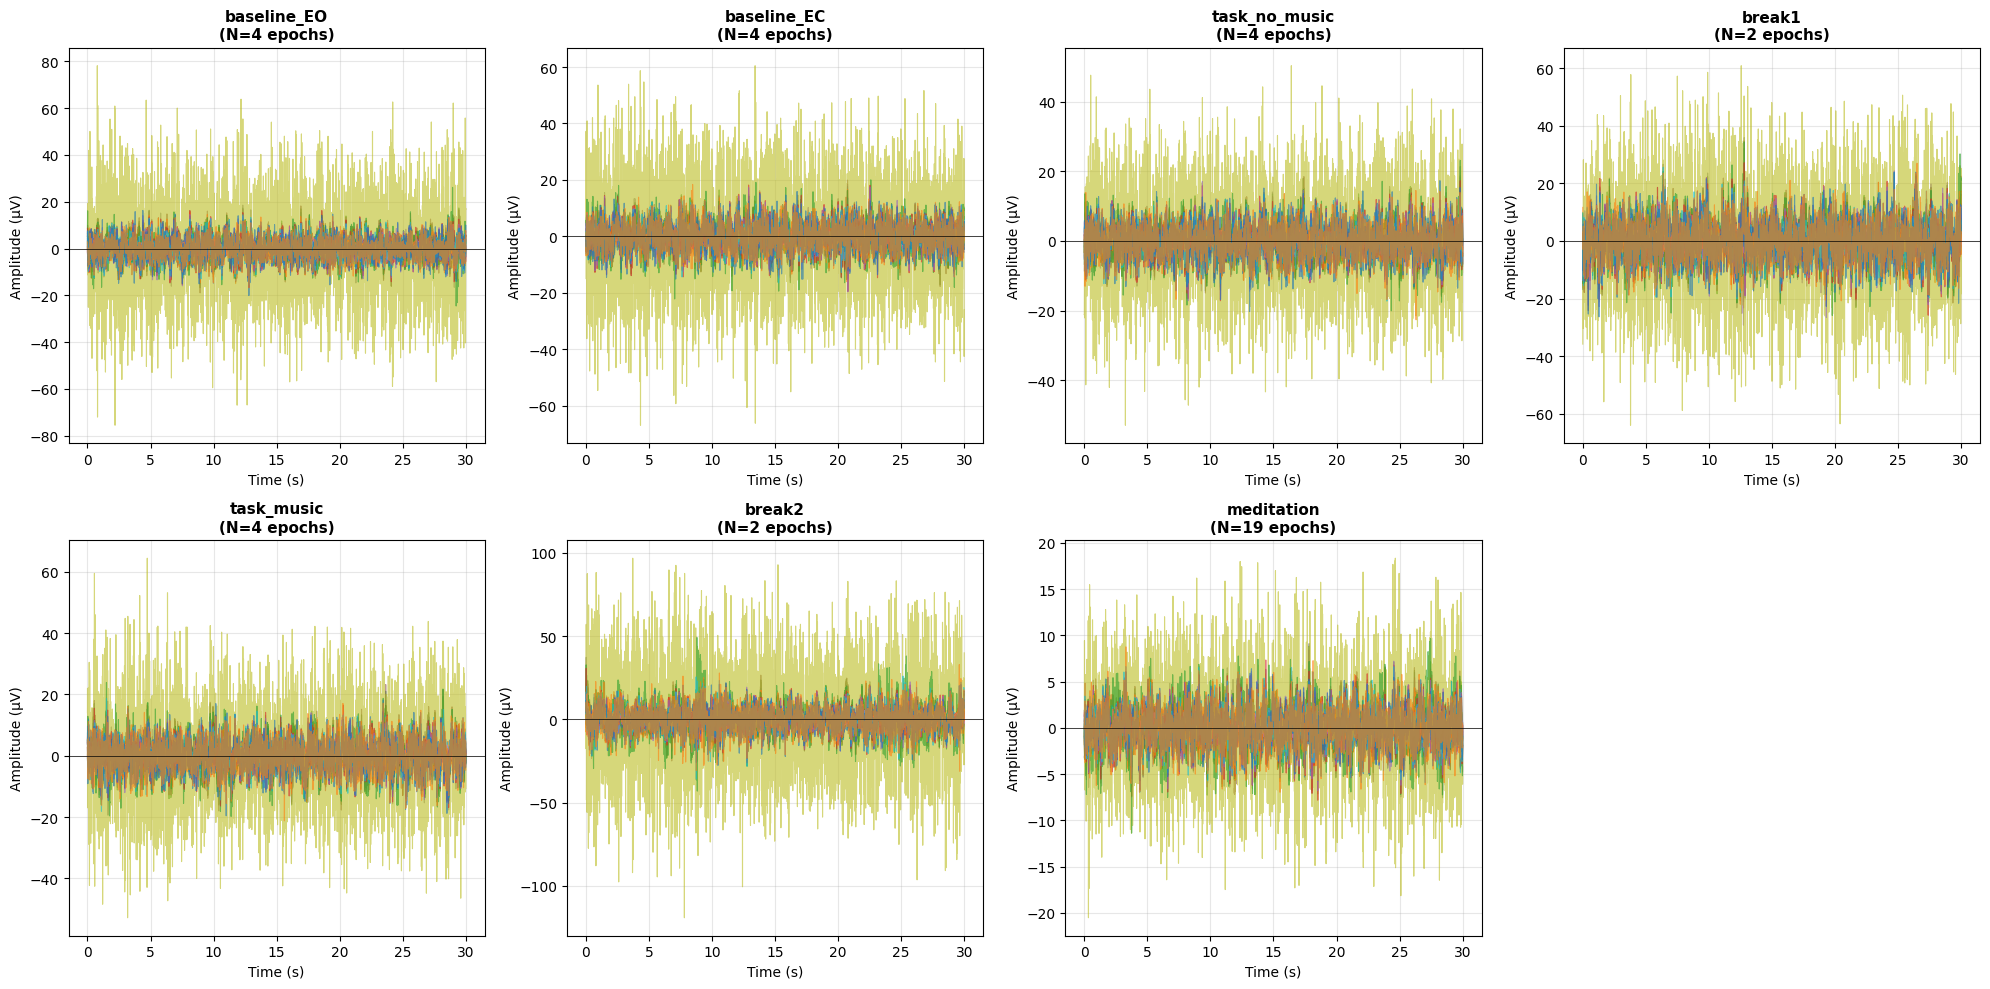

In [ ]:
# signal amplitude visualization
phases_with_data = [(name, epochs) for name, epochs in epochs_by_phase.items() if len(epochs) > 0]

n_phases = len(phases_with_data)
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for idx, (phase_name, epochs_phase) in enumerate(phases_with_data):
    evoked = epochs_phase.average()
    data = evoked.get_data()  # Shape: (n_channels, n_times)
    times = evoked.times
    
    for ch_idx in range(data.shape[0]):
        axes[idx].plot(times, data[ch_idx, :] * 1e6, alpha=0.6, linewidth=0.8)
    
    axes[idx].set_xlabel('Time (s)', fontsize=10)
    axes[idx].set_ylabel('Amplitude (µV)', fontsize=10)
    axes[idx].set_title(f'{phase_name}\n(N={len(epochs_phase)} epochs)', 
                       fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(0, color='black', linestyle='-', linewidth=0.5)

for idx in range(n_phases, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Observations 
- Meditation phase stands out:
    - Much lower amplitudes (-4 to 3 µV) vs others (-10 to 20 µV)
    - More stable signal
    - 315 epochs (longest phase)
- Consistent with a relaxed/meditative state
    - Task phases show higher activity:
    - task_no_music: highest amplitudes (-20 to 20 µV)
    - task_music: moderate amplitudes (-15 to 15 µV)
    - Expected during active tasks
- Baseline phases:
    - baseline_EO and baseline_EC: moderate amplitudes
    - baseline_EC slightly higher than baseline_EO (typical)
- Break phases:
    - Lower amplitudes, more stable
    - Consistent with rest periods

In [ ]:
# Summary table of epochs by phase
comprehensive_data = []

for phase_name, epochs_phase in epochs_by_phase.items():
    if len(epochs_phase) > 0:
        data = epochs_phase.get_data()
        phase_start, phase_end = labeled_phases[phase_name]
        
        # Overall statistics
        max_amp = np.abs(data).max() * 1e6
        mean_amp = np.abs(data).mean() * 1e6
        std_amp = data.std() * 1e6
        
        # Per-channel average
        channel_means = np.abs(data).mean(axis=(0, 2)) * 1e6
        max_channel_amp = channel_means.max()
        min_channel_amp = channel_means.min()
        mean_channel_amp = channel_means.mean()
        
        comprehensive_data.append({
            'Phase': phase_name,
            'N_Epochs': len(epochs_phase),
            'Start_s': phase_start,
            'End_s': phase_end,
            'Duration_s': phase_end - phase_start,
            'Duration_min': (phase_end - phase_start) / 60,
            'Max_Amp_µV': max_amp,
            'Mean_Amp_µV': mean_amp,
            'Std_Amp_µV': std_amp,
            'Max_Channel_Mean_µV': max_channel_amp,
            'Min_Channel_Mean_µV': min_channel_amp,
            'Mean_Channel_Mean_µV': mean_channel_amp
        })

comprehensive_df = pd.DataFrame(comprehensive_data)
comprehensive_df

,Phase,N_Epochs,Start_s,End_s,Duration_s,Duration_min,Max_Amp_µV,Mean_Amp_µV,Std_Amp_µV,Max_Channel_Mean_µV,Min_Channel_Mean_µV,Mean_Channel_Mean_µV
0,baseline_EO,4,116.072,236.072,120.000,2.0000,171.554685,7.034958,11.222831,31.039819,3.047797,7.034958
1,baseline_EC,4,236.072,356.072,120.000,2.0000,161.584482,6.879725,10.617348,27.895360,3.007418,6.879725
2,task_no_music,4,356.072,476.072,120.000,2.0000,117.898173,6.351568,9.300929,21.880613,2.732569,6.351568
3,break1,2,476.072,536.072,60.000,1.0000,95.856530,6.390750,9.157534,20.391770,2.876879,6.390750
4,task_music,4,536.072,656.072,120.000,2.0000,129.833449,6.757271,10.012769,23.397587,2.810400,6.757271
5,break2,2,656.072,716.072,60.000,1.0000,167.378128,7.348137,11.940928,33.153647,2.789637,7.348137
6,meditation,19,716.072,1302.038,585.966,9.7661,144.745104,6.120229,8.774866,17.336729,2.638833,6.120229


## 7. Power Analysis (Alpha & Theta)

### Extract power in alpha (8-13 Hz) and theta (4-8 Hz) frequency bands and compare between experimental phases (baseline, meditation, post-meditation)

In [ ]:
# Compute PSD for each experimental phase
psd_by_phase = {}

for phase_name, epochs_phase in epochs_by_phase.items():
    print(f"Computing PSD for {phase_name}...")
    psd_by_phase[phase_name] = epochs_phase.compute_psd(
        method='welch',
        fmin=1.0,
        fmax=40.0
    )
    print(f"  ✓ {phase_name}: {len(epochs_phase)} epochs, {len(psd_by_phase[phase_name].ch_names)} channels")

Computing PSD for baseline_EO...
Effective window size : 4.096 (s)
  ✓ baseline_EO: 4 epochs, 22 channels
Computing PSD for baseline_EC...
Effective window size : 4.096 (s)
  ✓ baseline_EC: 4 epochs, 22 channels
Computing PSD for task_no_music...
Effective window size : 4.096 (s)
  ✓ task_no_music: 4 epochs, 22 channels
Computing PSD for break1...
Effective window size : 4.096 (s)
  ✓ break1: 2 epochs, 22 channels
Computing PSD for task_music...
Effective window size : 4.096 (s)
  ✓ task_music: 4 epochs, 22 channels
Computing PSD for break2...
Effective window size : 4.096 (s)
  ✓ break2: 2 epochs, 22 channels
Computing PSD for meditation...
Effective window size : 4.096 (s)
  ✓ meditation: 19 epochs, 22 channels


In [ ]:
# Extract theta and alpha power for each phase
freq_bands = {
    'theta': (4, 8),   # Theta: 4-8 Hz
    'alpha': (8, 13),  # Alpha: 8-13 Hz
}

phase_power_results = {}

for phase_name, psd_phase in psd_by_phase.items():
    # Extract theta power (average across frequencies in band, across epochs)
    theta_power = psd_phase.get_data(fmin=4, fmax=8).mean(axis=-1).mean(axis=0)  # Shape: (n_channels,)
    
    # Extract alpha power
    alpha_power = psd_phase.get_data(fmin=8, fmax=13).mean(axis=-1).mean(axis=0)  # Shape: (n_channels,)
    
    # Convert from V²/Hz to µV²/Hz (1 µV = 1e-6 V, so 1 µV² = 1e-12 V²)
    theta_power_µV = theta_power * 1e12
    alpha_power_µV = alpha_power * 1e12
    
    # Calculate iAF ratio (alpha/theta)
    iaf_ratio = alpha_power_µV / theta_power_µV
    
    phase_power_results[phase_name] = {
        'theta': theta_power_µV,
        'alpha': alpha_power_µV,
        'iaf_ratio': iaf_ratio,
        'channels': psd_phase.ch_names
    }
    
    print(f"\n{phase_name}:")
    print(f"  Mean Theta Power: {theta_power_µV.mean():.4f} µV²/Hz")
    print(f"  Mean Alpha Power: {alpha_power_µV.mean():.4f} µV²/Hz")
    print(f"  Mean iAF Ratio: {iaf_ratio.mean():.4f}")


baseline_EO:
  Mean Theta Power: 2.0722 µV²/Hz
  Mean Alpha Power: 3.4822 µV²/Hz
  Mean iAF Ratio: 1.6920

baseline_EC:
  Mean Theta Power: 2.3980 µV²/Hz
  Mean Alpha Power: 2.9350 µV²/Hz
  Mean iAF Ratio: 1.2119

task_no_music:
  Mean Theta Power: 2.0845 µV²/Hz
  Mean Alpha Power: 2.2496 µV²/Hz
  Mean iAF Ratio: 1.1096

break1:
  Mean Theta Power: 2.3217 µV²/Hz
  Mean Alpha Power: 2.9172 µV²/Hz
  Mean iAF Ratio: 1.3068

task_music:
  Mean Theta Power: 2.3615 µV²/Hz
  Mean Alpha Power: 2.4309 µV²/Hz
  Mean iAF Ratio: 1.0842

break2:
  Mean Theta Power: 2.5849 µV²/Hz
  Mean Alpha Power: 2.5527 µV²/Hz
  Mean iAF Ratio: 0.9529

meditation:
  Mean Theta Power: 2.2972 µV²/Hz
  Mean Alpha Power: 2.4376 µV²/Hz
  Mean iAF Ratio: 1.1036


In [ ]:
# Df for analysis
import pandas as pd

results = []
for phase_name, power_data in phase_power_results.items():
    for ch_idx, ch_name in enumerate(power_data['channels']):
        results.append({
            'Phase': phase_name,
            'Channel': ch_name,
            'Theta_Power_µV²': power_data['theta'][ch_idx],
            'Alpha_Power_µV²': power_data['alpha'][ch_idx],
            'iAF_Ratio': power_data['iaf_ratio'][ch_idx]
        })

power_analysis_df = pd.DataFrame(results)
power_analysis_df  

,Phase,Channel,Theta_Power_µV²,Alpha_Power_µV²,iAF_Ratio
0,baseline_EO,FPz,2.336049,3.574383,1.530098
1,baseline_EO,FCz,1.643422,2.859314,1.739853
2,baseline_EO,F9,2.905888,3.601325,1.239320
3,baseline_EO,F3,1.850170,2.614883,1.413321
4,baseline_EO,F4,2.046689,3.063741,1.496926
...,...,...,...,...,...
149,meditation,P4,0.931055,1.006585,1.081123
150,meditation,P8,1.808906,1.577503,0.872076
151,meditation,P10,2.725870,2.535360,0.930110
152,meditation,O1,2.383198,3.133398,1.314787


In [ ]:
# Summary statistics by phase
summary = power_analysis_df.groupby('Phase').agg({
    'Theta_Power_µV²': ['mean', 'std'],
    'Alpha_Power_µV²': ['mean', 'std'],
    'iAF_Ratio': ['mean', 'std']
})
print("\n=== Summary Statistics by Phase ===")
print(summary)


=== Summary Statistics by Phase ===
              Theta_Power_µV²           Alpha_Power_µV²           iAF_Ratio  \
                         mean       std            mean       std      mean   
Phase                                                                         
baseline_EC          2.397989  1.183809        2.935025  2.349461  1.211924   
baseline_EO          2.072175  1.010547        3.482208  2.610373  1.691952   
break1               2.321729  1.084719        2.917164  1.352957  1.306766   
break2               2.584897  1.488138        2.552665  2.920030  0.952920   
meditation           2.297221  1.066093        2.437587  1.185850  1.103584   
task_music           2.361504  1.215232        2.430919  1.564523  1.084243   
task_no_music        2.084536  0.997358        2.249620  1.380999  1.109620   

                         
                    std  
Phase                    
baseline_EC    0.409220  
baseline_EO    0.444586  
break1         0.269798  
break2         0